# Difussion score matching
Working with *robust* posteriors via difussion score matching

In [1]:
import jax
import distrax
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt

2023-09-11 08:26:55.753102: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
%config InlineBackend.figure_format = "retina"

## The setting
### Proposition 3.1 of [1]
Suppose $y\vert\boldsymbol\theta$ is a member of the exponential family such that
$$
 p({\bf y} \vert \theta) = \exp(\eta(\boldsymbol\theta)^\intercal r(x) - a(\boldsymbol\theta) + b(x)).
$$

Take $\eta(\boldsymbol\theta) = \boldsymbol\theta$ and a squared exponential prior
$$
    \pi(\boldsymbol\theta)\propto
    \exp\left(-\frac{1}{2}(\boldsymbol\theta - \boldsymbol\mu)^\intercal\boldsymbol\Sigma^{-1}(\boldsymbol\theta - \boldsymbol\mu)\right)
$$

with
* $\eta: \boldsymbol\Theta \to \mathbb{R}^p$ the natural parameters,
* $r: {\cal X} \to \mathbb{R}^p$ the sufficient statistics,
* $a: \boldsymbol\Theta \to \mathbb{R}$ the log-partition and,
* $b: {\cal X} \to \mathbb{R}$ the log-base measure

Then the posterior takes the form of a truncated Gaussian of the form
$$
    \pi(\boldsymbol\theta \vert y_{1:t}) \propto
    \left(
        -\frac{1}{2}(\boldsymbol\theta - \boldsymbol\mu_T)^\intercal \boldsymbol\Sigma_T^{-1} (\boldsymbol\theta - \boldsymbol\mu_T)
    \right)
$$
with
* $\boldsymbol\Sigma_T^{-1} = \boldsymbol\Sigma^{-1} + 2\omega T \Lambda_T$
* $\boldsymbol\mu_T = \boldsymbol\Sigma_T (\boldsymbol\Sigma^{-1}\boldsymbol\mu - \omega T \nu_T)$
* $\Lambda_T = \frac{1}{T}\sum_{t=1}^T \Lambda(y_t)$
* $\nu_T = \frac{2}{T} \nu(y_t)$
* $\Lambda(y) = \left( \nabla r^\intercal m m^\intercal \nabla r \right)(y)$
* $\nu(y) = \left( \nabla r^\intercal m m^\intercal \nabla r^\intercal + \nabla\cdot (mm^\intercal)\nabla r_t \right)$
* $m: {\cal X} \to \mathbb{R}^{M\times M}$

## Example: $\epsilon$-contaminated Gaussian

Let

$$
a(\theta_1, \theta_2) = -\frac{\theta_1^2}{4\theta_2} - \frac{1}{2}\log(-2\theta_2)
$$

$$
    r(x) =
    \begin{bmatrix}
    x, x ^2
    \end{bmatrix}
$$

We consider ${\cal X} = \mathbb{R}^d$ so that $\nabla r(x) \in \mathbb{R}^{d\times p}$ for $x \in \mathbb{R}^d$.

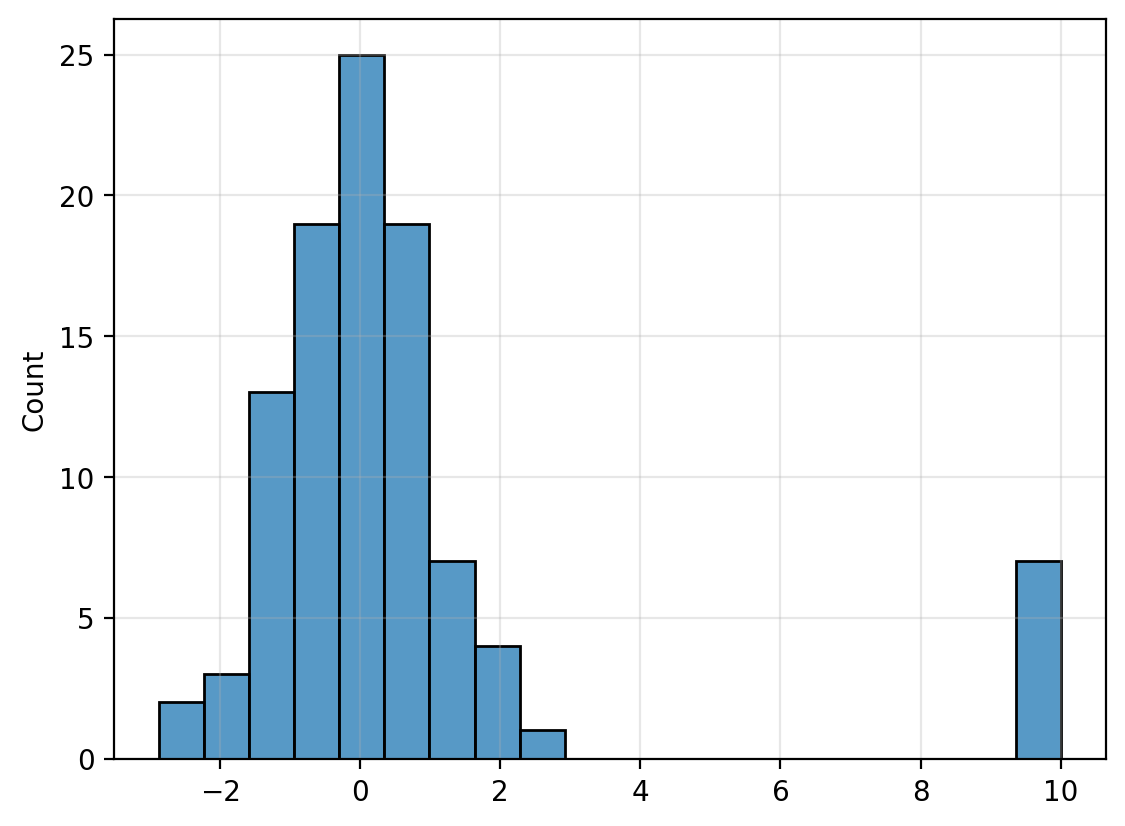

In [3]:
key = jax.random.PRNGKey(314)
mean, std = 0, 1

n_samples = 100
eps = 0.05
contamination = 10
key_data, key_epsilon = jax.random.split(key)
samples = jax.random.normal(key_data, shape=(n_samples,)) * std + mean
samples_contaminated = jax.random.bernoulli(key_epsilon, p=eps, shape=(n_samples,))

samples = samples * (1 - samples_contaminated) + contamination * (samples_contaminated)

sns.histplot(samples)
plt.grid(alpha=0.3)

In [4]:
def r(x):
    return jnp.array([[x, x ** 2]])

m = jnp.eye(1)
gradr_samples = jax.vmap(jax.jacfwd(r))(samples)

Lambda_samples = jnp.einsum("sji,jk,slk,lm->sik", gradr_samples, m, gradr_samples, m)
Lambda_T = Lambda_samples.mean(axis=0)

def div(x):
    gradr = jax.jacfwd(r)(x)
    return jnp.einsum("ij,kj,kl->il", m, m, gradr)

nu_samples = jax.vmap(jax.jacfwd(div))(samples) # grad(b) = 0 for univariate Gaussian
nu_T = nu_samples.mean(axis=0) * 2

mu_prior = jnp.array([[0, -1]]).T
Sigma_prior = jnp.diag(jnp.array([10, 1]))

omega = 1e-7

In [5]:
Sigma_post = jnp.linalg.inv(jnp.linalg.inv(Sigma_prior) + 2 * omega * n_samples * Lambda_T)
Sigma_post

Array([[ 9.9980011e+00, -2.6406976e-04],
       [-2.6406976e-04,  9.9936360e-01]], dtype=float32)

In [6]:
eta_post = Sigma_post @ (jnp.linalg.inv(Sigma_prior) @ mu_prior - omega * n_samples * nu_T.T)
eta_post

Array([[ 2.6408033e-04],
       [-9.9940366e-01]], dtype=float32)

In [7]:
# Robust posterior mean
posterior_mean_robust = -eta_post[0] / (2 * eta_post[1])
posterior_mean_robust

Array([0.00013212], dtype=float32)

In [8]:
# Robust posterior std
posterior_std_robust = jnp.sqrt(-1 / (2 * eta_post[1]))
posterior_std_robust

Array([0.70731777], dtype=float32)

## *Classical* posterior

In [9]:
mu0, eta, alpha, beta = 0, 1, 3, 3

mu_post = (eta * mu0 + n_samples * samples.mean()) / (eta + n_samples)
eta_post = eta + n_samples
alpha_post = alpha + n_samples / 2
beta_post = beta + jnp.sum((samples - samples.mean()) ** 2) + n_samples * eta / (n_samples + eta) * (samples.mean() - mu0) ** 2 / 2

In [10]:
# Posterior mean
posterior_mean = mu_post.copy()
posterior_mean

Array(0.65418506, dtype=float32)

In [11]:
# Posterior std
posterior_std = jnp.sqrt(beta_post / (alpha_post - 1)).copy()
posterior_std

Array(3.811991, dtype=float32)

## Comparison

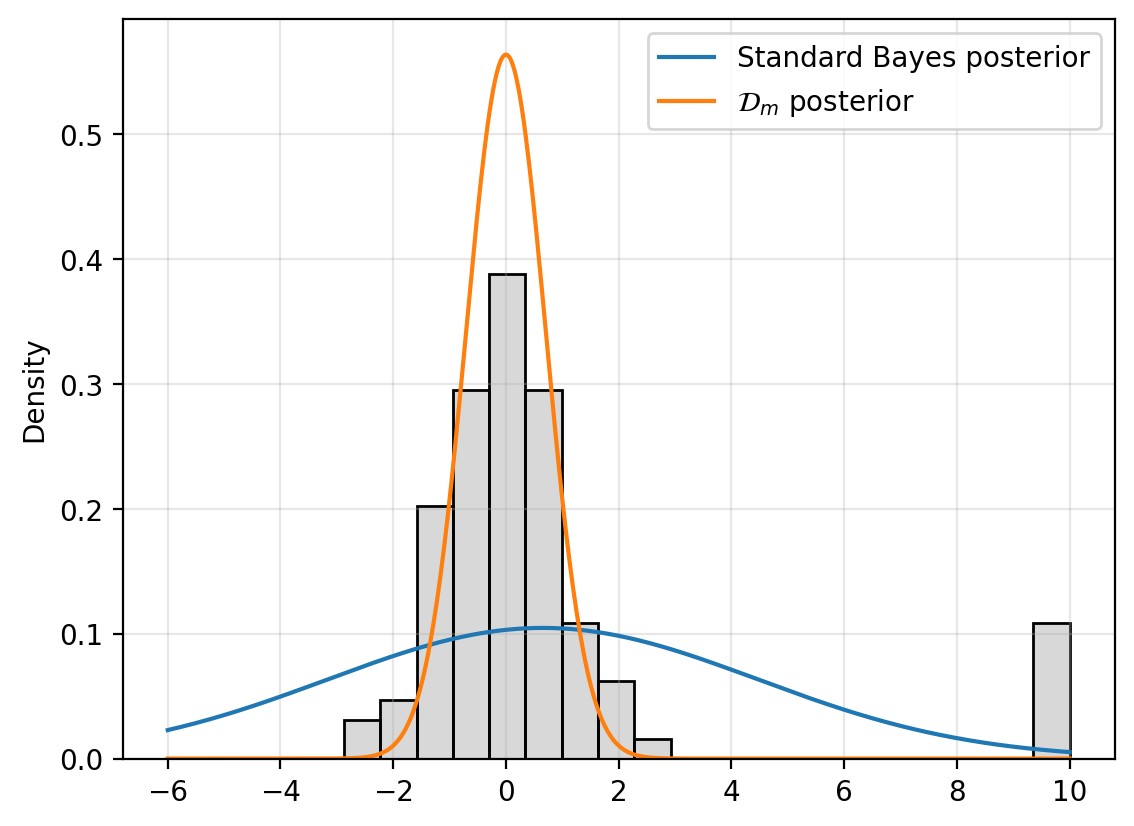

In [12]:
xrange = jnp.linspace(-6, 10, 500)
bayes_post = distrax.Normal(posterior_mean, posterior_std)
robust_post = distrax.Normal(posterior_mean_robust, posterior_std_robust)

sns.histplot(samples, color="tab:gray", stat="density", alpha=0.3)
plt.plot(xrange, bayes_post.prob(xrange), label="Standard Bayes posterior")
plt.plot(xrange, robust_post.prob(xrange), label=r"${\cal D}_m$ posterior")
plt.legend()
plt.grid(alpha=0.3)

# References
* [1] Robust and Scalable Bayesian Online Changepoint Detection: https://arxiv.org/abs/2302.04759
* [2] Table of exponential family distributions: https://en.wikipedia.org/wiki/Exponential_family#Table_of_distributions